In [3]:
"""
Source-Only WGAN-GP Training Script

This script trains a WGAN-GP model using only the source domain data, without domain adaptation.
- Training: Source domain training set
- Validation: Source domain validation set  
- Testing: Target domain validation set (to measure generalization performance)

The model architecture remains the same, but no domain adaptation techniques (JMMD) are applied.
"""
import tensorflow as tf

import os
import sys
import numpy as np
from scipy.io import savemat
import h5py

# Add the root project directory
try:
    code_dir = os.path.dirname(os.path.abspath(__file__))
    project_root = os.path.abspath(os.path.join(code_dir, '..', '..', '..'))
except NameError:
    # Running in Jupyter Notebook
    code_dir = os.getcwd()
    project_root = os.path.abspath(os.path.join(code_dir, '..', '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(code_dir)
print(project_root) # Hest_NTN_UDA/

from Domain_Adversarial.helper import loader, plotfig, PAD
from Domain_Adversarial.helper.utils import H5BatchLoader
from Domain_Adversarial.helper.utils_GAN import visualize_H
from JMMD.helper.utils_GAN import save_checkpoint_jmmd as save_checkpoint

SNR = -5
# source_data_file_path_label = os.path.abspath(os.path.join(code_dir, '..', 'generatedChan', 'OpenNTN','H_perfect.mat'))
source_data_file_path = os.path.abspath(os.path.join(code_dir, '..', '..', '..', 'generatedChan', 'MATLAB', 'TDL_A', f'SNR_{SNR}dB', 'matlabNTN.mat'))
target_data_file_path = os.path.abspath(os.path.join(code_dir, '..', '..', '..', 'generatedChan', 'MATLAB', 'TDL_C', f'SNR_{SNR}dB', 'matlabNTN.mat'))
norm_approach = 'minmax' # can be set to 'std'
lower_range = -1 
    # if norm_approach = 'minmax': 
        # =  0 for scaling to  [0 1]
        # = -1 for scaling to [-1 1]
    # if norm_approach = 'std': can be any value, but need to be defined
weights = {
    # Core loss weights
    'adv_weight': 0.005,        # GAN adversarial loss weight
    'est_weight': 1.0,          # Estimation loss weight (main task)
    'domain_weight': 0.0,      # No domain_weight since we're not doing domain adaptation
    
    # Smoothness regularization weights
    'temporal_weight': 0.02,    # Temporal smoothness penalty
    'frequency_weight': 0.1,    # Frequency smoothness penalty
}

if norm_approach == 'minmax':
    if lower_range == 0:
        norm_txt = 'Using min-max [0 1]'
    elif lower_range ==-1:
        norm_txt = 'Using min-max [-1 1]'
elif norm_approach == 'no':
    norm_txt = 'No'
    
# Paths to save
idx_save_path = loader.find_incremental_filename(project_root + '/JMMD/model/GAN','ver', '_', '')

save_model = 1
model_path = project_root + '/JMMD/model/GAN/ver' + str(idx_save_path) + '_'
# figure_path = code_dir + '/model/GAN/ver' + str(idx_save_path) + '_/figure'
model_readme = model_path + '/readme.txt'

batch_size=16

# ============ Source data ==============
source_file = h5py.File(source_data_file_path, 'r')
H_true_source = source_file['H_perfect']
N_samp_source = H_true_source.shape[0]
print('N_samp_source = ', N_samp_source)

# ============ Target data ==============
target_file = h5py.File(target_data_file_path, 'r')
H_true_target = target_file['H_perfect']
N_samp_target = H_true_target.shape[0]
print('N_samp_target = ', N_samp_target)

# Store random state 
rng_state = np.random.get_state()

# --- Set a temporary seed for reproducible split ---
np.random.seed(1234)   # any fixed integer seed
# Random but repeatable split
indices_source = np.arange(N_samp_source)
np.random.shuffle(indices_source)
indices_target = np.arange(N_samp_target)
np.random.shuffle(indices_target)
# Restore previous random state (so other code stays random)
np.random.set_state(rng_state)
#
train_size = int(np.floor(N_samp_source * 0.9) // batch_size * batch_size)
val_size = N_samp_source - train_size

# Repeat the indices to match the maximum number of samples
N_samp = max(N_samp_source, N_samp_target) 
indices_source = np.resize(indices_source, N_samp)
indices_target = np.resize(indices_target, N_samp)

# =======================================================
## Divide the indices into training and validation sets
# indices_train_source = indices_source[:train_size]
# indices_val_source   = indices_source[train_size:train_size + val_size]

# indices_train_target = indices_target[:train_size]
# indices_val_target   = indices_target[train_size:train_size + val_size]

# to test code
indices_train_source = indices_source[:96]
indices_val_source = indices_source[2032:]
indices_train_target = indices_target[:96]
indices_val_target = indices_target[2032:]

print('train_size = ', indices_train_source.shape[0])
print('val_size = ', indices_val_source.shape[0])

class DataLoaders:
    def __init__(self, file, indices_train, indices_val, tag='prac', batch_size=32): 
        # tag = 'prac' or 'li' or 'ls'
        self.true_train = H5BatchLoader(file, dataset_name='H_perfect', batch_size=batch_size, shuffled_indices=indices_train)
        self.true_val = H5BatchLoader(file, dataset_name='H_perfect', batch_size=batch_size, shuffled_indices=indices_val)

        self.input_train = H5BatchLoader(file, f'H_{tag}', batch_size=batch_size, shuffled_indices=indices_train)
        self.input_val = H5BatchLoader(file, f'H_{tag}', batch_size=batch_size, shuffled_indices=indices_val)

# Source domain
class_dict_source = {
    'GAN_practical': DataLoaders(source_file, indices_train_source, indices_val_source, tag='prac', batch_size=batch_size),
    'GAN_linear': DataLoaders(source_file, indices_train_source, indices_val_source, tag='li', batch_size=batch_size),
    'GAN_ls': DataLoaders(source_file, indices_train_source, indices_val_source, tag='ls', batch_size=batch_size)
}

# Target domain
class_dict_target = {
    'GAN_practical': DataLoaders(target_file, indices_train_target, indices_val_target, tag='prac', batch_size=batch_size),
    'GAN_linear': DataLoaders(target_file, indices_train_target, indices_val_target, tag='li', batch_size=batch_size),
    'GAN_ls': DataLoaders(target_file, indices_train_target, indices_val_target, tag='ls', batch_size=batch_size)
}

loss_fn_ce = tf.keras.losses.MeanSquaredError()  # Channel estimation loss (generator loss)
loss_fn_bce = tf.keras.losses.BinaryCrossentropy(from_logits=False) # Binary cross-entropy loss for discriminator

from JMMD.helper.utils_GAN import GAN
from JMMD.helper.utils_GAN import train_step_wgan_gp_source_only, val_step_wgan_gp_source_only, post_val

import time
start = time.perf_counter()

n_epochs= 5
epoch_min = 0
epoch_step = 1
# n_epochs= 3
# epoch_min = 0
# epoch_step = 1

sub_folder_ = ['GAN_practical']  # ['GAN_linear', 'GAN_practical', 'GAN_ls']



/home/thien/Code/NTN/Hest_NTN_UDA/JMMD/computeCA/run_JMMD_GAN
/home/thien/Code/NTN/Hest_NTN_UDA
N_samp_source =  2048
N_samp_target =  2048
train_size =  96
val_size =  16


Processing: GAN_practical
Calculating Wasserstein-1 distance for original input training datasets (before training)...
X shape =  (192, 528)
X1 shape =  (96, 528) y1 shape =  (96,)
(96, 528) (96,)
C: 0.01, Error rate: 0.5208
C: 0.1, Error rate: 0.3125
C: 0.5, Error rate: 0.1562
C: 1.0, Error rate: 0.0938
C: 2.0, Error rate: 0.0208
C: 5.0, Error rate: 0.0104
C: 10.0, Error rate: 0.0000
C: 50.0, Error rate: 0.0000
C: 100.0, Error rate: 0.0000
C: 500.0, Error rate: 0.0000
C: 1000.0, Error rate: 0.0000
Best C: 10.0, Best error rate: 0.0000
PAD = 2.0000
PAD = 2.0000
Fitted PCA on batch: source 96/96, target 96/96
Reduced source shape: (96, 100), target shape: (96, 100)
== C: 0.01, Error rate: 0.5208
== C: 0.1, Error rate: 0.5208
== C: 0.5, Error rate: 0.1146
== C: 1.0, Error rate: 0.1042
== C: 2.0, Error rate: 0.0938
== C: 5.0, Error rate: 0.0938
== C: 10.0, Error rate: 0.0938
== C: 50.0, Error rate: 0.0938
== C: 100.0, Error rate: 0.0938
== C: 500.0, Error rate: 0.0938
== C: 1000.0, Error 

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

<Figure size 640x480 with 0 Axes>

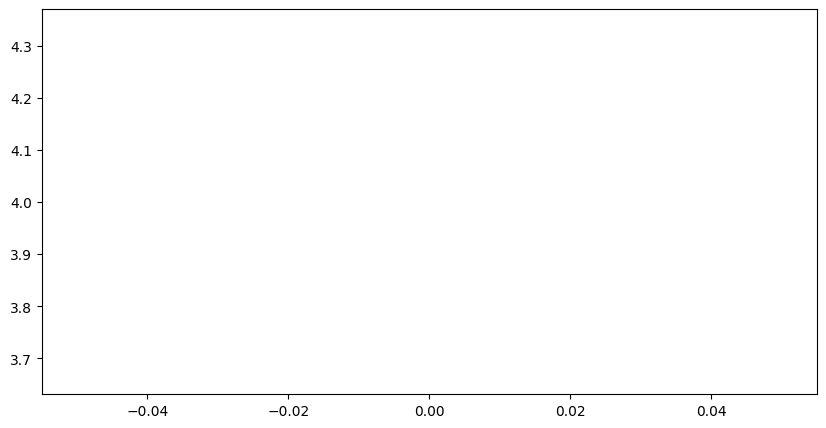

In [5]:
for sub_folder in sub_folder_:
    print(f"Processing: {sub_folder}")
    pad_metrics = {
        'pad_pca_lda': {},      # Dictionary to store LDA PAD values by epoch
        'pad_pca_logreg': {},   # Dictionary to store LogReg PAD values by epoch
        'pad_pca_svm': {},      # Dictionary to store SVM PAD values by epoch
        'w_dist': {}            # Dictionary to store Wasserstein distances by epoch
    }
    linear_interp = False
    if sub_folder == 'GAN_linear':
        linear_interp =True # flag to clip values that go beyond the estimated pilot (min, max)
    ##
    loader_H_true_train_source = class_dict_source[sub_folder].true_train
    loader_H_input_train_source = class_dict_source[sub_folder].input_train
    loader_H_true_val_source = class_dict_source[sub_folder].true_val
    loader_H_input_val_source = class_dict_source[sub_folder].input_val
    
    loader_H_true_train_target = class_dict_target[sub_folder].true_train
    loader_H_input_train_target = class_dict_target[sub_folder].input_train
    loader_H_true_val_target = class_dict_target[sub_folder].true_val
    loader_H_input_val_target = class_dict_target[sub_folder].input_val
    ##
    
    # Distribution of original input training datasets (or before training)    
    plotfig.plotHist(loader_H_input_train_source, fig_show = False, save_path=f"{model_path}/{sub_folder}/Distribution/", name='source_beforeTrain', percent=100)
    plotfig.plotHist(loader_H_input_train_target, fig_show = False, save_path=f"{model_path}/{sub_folder}/Distribution/", name='target_beforeTrain', percent=100)
    
    plotfig.plotHist(loader_H_input_train_source, fig_show = False, save_path=f"{model_path}/{sub_folder}/Distribution/", name='source_beforeTrain', percent=99)
    plotfig.plotHist(loader_H_input_train_target, fig_show = False, save_path=f"{model_path}/{sub_folder}/Distribution/", name='target_beforeTrain', percent=99)
    
    plotfig.plotHist(loader_H_input_train_source, fig_show = False, save_path=f"{model_path}/{sub_folder}/Distribution/", name='source_beforeTrain', percent=95)
    plotfig.plotHist(loader_H_input_train_target, fig_show = False, save_path=f"{model_path}/{sub_folder}/Distribution/", name='target_beforeTrain', percent=95)

    plotfig.plotHist(loader_H_input_train_source, fig_show = False, save_path=f"{model_path}/{sub_folder}/Distribution/", name='source_beforeTrain', percent=90)
    plotfig.plotHist(loader_H_input_train_target, fig_show = False, save_path=f"{model_path}/{sub_folder}/Distribution/", name='target_beforeTrain', percent=90)

    # Calculate Wasserstein-1 distance for original input training datasets (before training)
    print("Calculating Wasserstein-1 distance for original input training datasets (before training)...")
    w_dist_epoc = plotfig.wasserstein_approximate(loader_H_input_train_source, loader_H_input_train_target)
    pad_metrics['w_dist']['before_training'] = w_dist_epoc
    
    # Calculate     PAD for original input training datasets with SVM
    pad_svm = PAD.original_PAD(loader_H_input_train_source, loader_H_input_train_target)
    print(f"PAD = {pad_svm:.4f}")
    
    # Calculate PCA_PAD for original input training datasets with PCA_SVM, PCA_LDA, PCA_LogReg
    X_features_, y_features_ = PAD.extract_features_with_pca(loader_H_input_train_source, loader_H_input_train_target, pca_components=100)
    pad_pca_svm_epoc = PAD.calc_pad_svm(X_features_, y_features_)
    pad_pca_lda_epoc = PAD.calc_pad_lda(X_features_, y_features_)
    pad_pca_logreg_epoc = PAD.calc_pad_logreg(X_features_, y_features_)
    
    pad_metrics['pad_pca_lda']['before_training'] = pad_pca_lda_epoc
    pad_metrics['pad_pca_logreg']['before_training'] = pad_pca_logreg_epoc  
    pad_metrics['pad_pca_svm']['before_training'] = pad_pca_svm_epoc
    ## 
    
    if not os.path.exists(os.path.dirname(model_path + '/' + sub_folder +'/')):
        os.makedirs(os.path.dirname(model_path + '/' + sub_folder + '/'))   # Domain_Adversarial/model/_/ver_/{sub_folder}

    #
    train_metrics = {
        'train_loss': [],           # total training loss 
        'train_est_loss': [],       # estimation loss
        'train_disc_loss': [],      # discriminator loss
        'train_domain_loss': [],    # JMMD loss (replaces domain loss)
        'train_est_loss_target': [] # target estimation loss (monitoring)
    }
    
    # 
    val_metrics = {
        'val_loss': [],                 # total validation loss
        'val_gan_disc_loss': [],        # GAN discriminator loss
        'val_domain_disc_loss': [],     # JMMD loss (replaces domain discriminator)
        'val_est_loss_source': [],      # source estimation loss
        'val_est_loss_target': [],      # target estimation loss  
        'val_est_loss': [],             # average estimation loss
        'source_acc': [],               # source domain accuracy (placeholder for JMMD)
        'target_acc': [],               # target domain accuracy (placeholder for JMMD)
        'acc': [],                      # average accuracy (placeholder for JMMD)
        'nmse_val_source': [],          # source NMSE
        'nmse_val_target': [],          # target NMSE
        'nmse_val': [],                  # average NMSE
        'val_smoothness_loss': []
    }
    #
    H_to_save = {}          # list to save to .mat file for H
    perform_to_save = {}    # list to save to .mat file for nmse, losses,...

    # 
    model = GAN(n_subc=312, gen_l2=None, disc_l2=1e-5)  # l2 regularization for generator and discriminator
    # 
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9)  # WGAN-GP uses Adam optimizer with beta_1=0.5
    # 
    ####
    optimizer = [gen_optimizer, disc_optimizer]  # 
    ####
    
    flag = 1 # flag to plot and save H_true
    epoc_pad = []    # epochs that calculating pad (return_features == True)
    for epoch in range(n_epochs):
        # ===================== Training =====================
        loader_H_true_train_source.reset()
        # loader_H_practical_train_source.reset()
        loader_H_input_train_source.reset()
        loader_H_true_train_target.reset()
        # loader_H_practical_train_target.reset()
        loader_H_input_train_target.reset()
                
        # loader_H = [loader_H_practical_train_source, loader_H_true_train_source, loader_H_practical_train_target, loader_H_true_train_target]
        loader_H = [loader_H_input_train_source, loader_H_true_train_source, loader_H_input_train_target, loader_H_true_train_target]

        # Only 2 loss functions needed for JMMD
        loss_fn = [loss_fn_ce, loss_fn_bce]
    
        ##########################
        if epoch in [int(n_epochs * r) for r in [0, 0.25, 0.5, 0.75]] or epoch == n_epochs-1:
            # return_features == return features to calculate PAD
            return_features = True
            epoc_pad.append(epoch)
        else:
            return_features = False

        ##########################
        # 
        train_step_output = train_step_wgan_gp_source_only(model, loader_H, loss_fn, optimizer, lower_range=-1, 
                        save_features=return_features, weights=weights, linear_interp=linear_interp)

        train_epoc_loss_est        = train_step_output.avg_epoc_loss_est
        train_epoc_loss_d          = train_step_output.avg_epoc_loss_d
        train_epoc_loss_domain     = train_step_output.avg_epoc_loss_domain  # Now contains JMMD loss
        train_epoc_loss            = train_step_output.avg_epoc_loss
        train_epoc_loss_est_target = train_step_output.avg_epoc_loss_est_target
                # train_epoc_loss        = total train loss = loss_est + lambda_jmmd * jmmd_loss
                # train_epoc_loss_est    = loss in estimation network in source domain (labels available)
                # train_epoc_loss_domain = JMMD loss (statistical distribution matching)
                # train_epoc_loss_est_target - just to monitor - the machine can not calculate because no label available in source domain
                # All are already calculated in average over training dataset (source/target - respectively)
        print("Time", time.perf_counter() - start, "seconds")
        # Note: No PAD calculation for source-only training since we're not doing domain adaptation
            
        
        # Average loss for the epoch
        train_metrics['train_loss'].append(train_epoc_loss)
        print(f"epoch {epoch+1}/{n_epochs} Average Training Loss: {train_epoc_loss:.6f}")
        
        train_metrics['train_est_loss'].append(train_epoc_loss_est)
        print(f"epoch {epoch+1}/{n_epochs} Average Estimation Loss (in Source domain): {train_epoc_loss_est:.6f}")
        
        train_metrics['train_disc_loss'].append(train_epoc_loss_d)
        print(f"epoch {epoch+1}/{n_epochs} Average Disc Loss (in Source domain): {train_epoc_loss_d:.6f}")
        
        train_metrics['train_domain_loss'].append(train_epoc_loss_domain)
        print(f"epoch {epoch+1}/{n_epochs} Source-only training (No domain adaptation): {train_epoc_loss_domain:.6f}")  # Updated print message
        
        train_metrics['train_est_loss_target'].append(train_epoc_loss_est_target)
        print(f"epoch {epoch+1}/{n_epochs} Testing performance on Target domain: {train_epoc_loss_est_target:.6f}")
        
        
        # ===================== Evaluation =====================
        loader_H_true_val_source.reset()
        loader_H_input_val_source.reset()
        loader_H_true_val_target.reset()
        loader_H_input_val_target.reset()
        loader_H_eval = [loader_H_input_val_source, loader_H_true_val_source, loader_H_input_val_target, loader_H_true_val_target]

        # 
        loss_fn = [loss_fn_ce, loss_fn_bce]
        
        # eval_func = utils_UDA_FiLM.val_step
        if (epoch==epoch_min) or (epoch+1>epoch_min and (epoch-epoch_min)%epoch_step==0) or epoch==n_epochs-1:
            # 
            H_sample, epoc_val_return = val_step_wgan_gp_source_only(model, loader_H_eval, loss_fn, lower_range, 
                                            weights=weights, linear_interp=linear_interp)
            visualize_H(H_sample, H_to_save, epoch, plotfig.figChan, flag, model_path, sub_folder, domain_weight=0.0)
            flag = 0  # after the first epoch, no need to save H_true anymore
            
        else:
            # 
            _, epoc_val_return = val_step_wgan_gp_source_only(model, loader_H_eval, loss_fn, lower_range, 
                                        weights=weights, linear_interp=linear_interp)
        
        post_val(epoc_val_return, epoch, n_epochs, val_metrics, domain_weight=0.0)
        
        if (epoch==epoch_min) or (epoch+1>epoch_min and (epoch-epoch_min)%epoch_step==0) or epoch==n_epochs-1:
            # 
            all_metrics = {
                'figLoss': plotfig.figLoss, 
                'savemat': savemat,
                'pad_metrics': pad_metrics, 
                'epoc_pad': epoc_pad,
                'pad_svm': pad_svm, 
                'weights': weights, 
                'optimizer': optimizer
            }
            # Combine all metrics
            all_metrics.update(train_metrics)  # Add training metrics
            all_metrics.update(val_metrics)    # Add validation metrics

            save_checkpoint(model, save_model, model_path, sub_folder, epoch, all_metrics)
    
    # end of epoch loop
    # =====================            
    # Save performances
    # Save H matrix
    savemat(model_path + '/' + sub_folder + '/H_visualize/H_trix.mat', H_to_save)
